# **Challenge 2 - K Nearest Neighbors**
* Sahil Gill, Luke Ingram
* MATH 318 - Winter 2023      

In [2]:

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import numpy as np 
import pandas as pd
import cv2
import glob
import os
import itertools


## **Section 1 - Loading the Data**

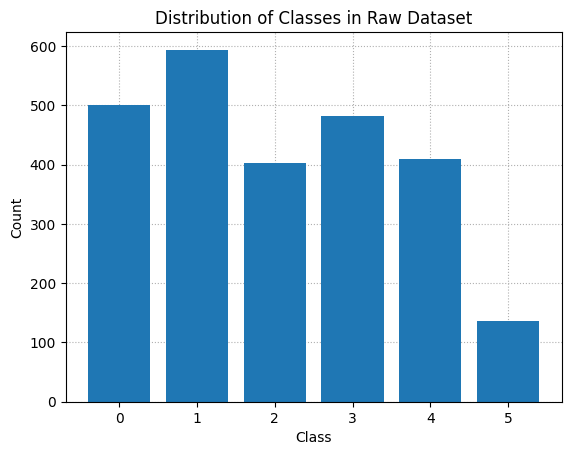

In [3]:
TARGET_NAMES =["Glass","Paper","Cardboard","Plastic","Metal","Trash"]

dirName = "../src/data/archive/zero-indexed-files.txt"
imgPath = "../src/data/archive/Garbage_classification/load/"

df = pd.read_csv(dirName,sep=' ')
df['image'] = imgPath + df['image'].astype(str)
df['image'] = df['image'].apply(lambda x: cv2.imread(x))

plt.clf()
plt.rc('axes', axisbelow=True)
plt.grid(linestyle='dotted')
temp = plt.bar(list(range(6)),
                np.unique(df['class'],return_counts=True)[1])
_ = plt.title("Distribution of Classes in Raw Dataset")
_ = plt.xlabel("Class")
_ = plt.ylabel("Count")

plt.show()

In our dataset the class labels are assigned as follows:

0. Glass

1. Paper

2. Cardboard

3. Plastic

4. Metal

5. Trash

Above, we've prepared a dataframe containing filepaths and their respective classes. Now we need to extract our design matrix.

Previously, we introduced SIFT, an algorithm for keypoint and image descriptor generation. The algorithm outputs a keypoint object, a datatype that efficiently encodes both the keypoints and image descriptors for each image. However, if we use KNN, we must transform our data into a discrete set of features whose entries can be evaluated with a distance metric.

## **Section 2 - Descriptor to KNN Pipeline**
The process of generating said feature space involves three steps.

1. **Extracting Keypoints & Descriptors**

2. **Clustering** (Feature Reduction)

3. **Normalization & Discretization**

A sample pipeline can be found below:

![](images/bagoffeatures_visualwordsoverview.png)

**Section 2.1 - Keypoints and Descriptors**

Given the definitions of Keypoints and Descriptors in the previous challenge, let's consider the code needed to compute these as:

In [4]:
# SIFT obtains & returns image descriptors
def SIFT(img):
    # normalize
    norm = cv2.normalize(img,np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
    sift = cv2.SIFT_create() 
    kps,des = sift.detectAndCompute(norm,None) 
    return kps,des

### **Section 2.2 - K-Means Clustering**

K-Means clustering is an important component in understanding how peer-class images interact with one another through their clusterings. We can present this with the following function, using sklearn:

In [5]:
# Using K-Means clustering for feature reduction. 
# Optimal K is determined by elbow method (see elbow_kmeans.py)
def cluster(descriptors,k = 15):
    clusters = KMeans(k,random_state=42,n_init='auto').fit(descriptors)
    return clusters 

For our purposes, we utilize kmeans to cluster the image descriptors.

To find our optimal value of K we will utilize the elbow method:

In [6]:
def elbow_kmeans(data,kmax=60): 
    # Optimize
    # Euclidean distance between clusters, 'Inertia'
    dist = []
    K = []

    for k in tqdm(range(1,kmax,3)): #Minimum is number of classes
        kmeans = KMeans(n_clusters=k,random_state=0,n_init='auto')
        kmeans.fit(data)
        dist.append(kmeans.inertia_)
        K.append(k)
    
    plt.plot(K,dist,'bx-')
    plt.xlabel("K")
    plt.ylabel("Distance")
    plt.title("Elbow Optimization for Kmeans using the Inertia method")
    plt.show()


By the plot, we can see why it is called the *elbow* method. Our optimal value of k is given by the crux of the *elbow* or the point in which the *Inertia* becomes monotonically decreasing. By *Inertia* we really mean the Euclidean Distance between the center of our clusters or *centroids*. 

### **Section 2.3 - Normalization & Discretization**

It's important for us to normalize our data; or in other words transform our images into binary, which according to the SIFT paper, provides us with more floating point precision between [0, 1]. Given these descriptors, to mitigate noise and to reduce dimensionality, we might cluster these descriptors and apply discretization. In essence, given a cluster of descriptors, we can drop these descriptors in a corresponding bin in a histogram, which allows us to decrease dimensionality while also increasing the order of our descriptors.

In [7]:
# Data binning through normalized histograms. 
def binData(keypoints,descriptors,clusters):

    hists = []
    for kps,des in zip(keypoints,descriptors):
        hist = np.zeros(len(clusters.labels_))
        bin = clusters.predict([des])
        hist[bin] += 1/len(kps)
        hists.append(hist)
    return hists

The function above generates an image histogram that essentially bins the descriptors. Descriptors "find their best" match, and are thus matched to their nearest bin/cluster. In computer vision and natural language processing, this histogram type data structure is referred to a "bag of words".

## **Section 3 - KNN Classification**

We can begin to classify using KNN. In this code block, we combine every topic introduced so far; obtaining the data, performing K-Means, and Discretization to prepare for Cross Validation and KNN with an optimal K.

First we load our training data & use the elbow method to compute the optimal clustering for our descriptors.

In [8]:
# Split data into training & testing sets
train_X,test_X,train_Y,test_Y = train_test_split(df['image'],df['class'],
                                                 test_size=0.33,random_state=42,stratify=df['class'])


# Fetch keypoints from training data
train_keys = []
train_des = []
for sample in train_X: 
    kps,des = SIFT(sample)
    train_keys.append(kps)
    for d in des: 
        train_des.append(d)

# find optimal clustering
#elbow_kmeans(train_des,kmax=60)

According to out plot, the optimal number of cluster is 15. So we use this value to cluster our data, and then continue onto the data binning(descritization) process.

In [9]:
# cluster data with said optimal value (from elbow)
kmeans = cluster(train_des,k = 60)

# Histogram with new clusters
train_hists = binData(train_keys,train_des,kmeans)

# Now Histogram the testing data using kmeans from training
test_keys = []
test_des = [] 
for sample in test_X: 
    kps,des = SIFT(sample)
    test_keys.append(kps)
    for d in des:
        test_des.append(d)

test_hists = binData(test_keys,test_des,kmeans)

### **Section 3.1 - K-Fold Cross Validation**

We need to define a Cross Validation function:

100%|██████████| 19/19 [11:51<00:00, 37.47s/it]


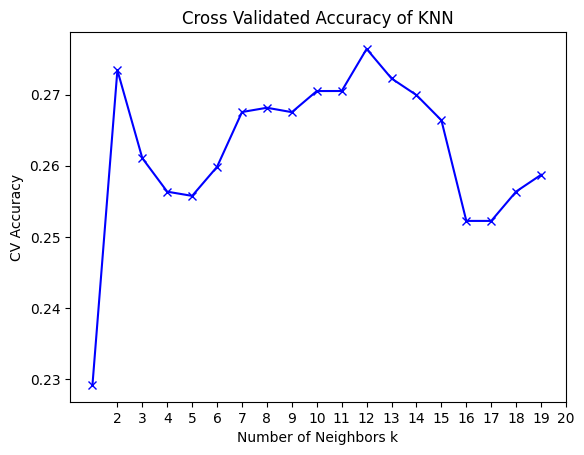

In [10]:
def crossValidate(X,Y,folds=10,kmax = 10):
    kscores = []
    for i in tqdm(range(1,kmax)):
        knn = KNeighborsClassifier(n_neighbors=i,n_jobs=8) # 5 parallel tasks to speed things up
        cv = cross_val_score(knn,X,Y,cv=folds,scoring="accuracy")
        kscores.append(cv.mean())
    
    plt.plot(list(range(1,kmax)),kscores,'bx-')  
    plt.xlabel("Number of Neighbors k")
    plt.ylabel("CV Accuracy")
    plt.title("Cross Validated Accuracy of KNN")
    plt.xticks(np.arange(1,kmax)+1) 
    plt.show()

    
crossValidate(train_hists,train_Y,kmax=20)

### **Section 3.2 - Classifying with Optimized K**
By looking at our plots, we determined that the optimal K=11. Thus, we can approach using 11NN.

In [10]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(train_hists,train_Y)

res = knn.predict(test_hists)

After fitting & predicting with our optimal value of k, we can evaluate our classifier with this function.

              precision    recall  f1-score   support

       Glass       0.26      0.46      0.33       166
       Paper       0.36      0.46      0.40       196
   Cardboard       0.16      0.07      0.10       133
     Plastic       0.25      0.24      0.25       159
       Metal       0.22      0.13      0.16       135
       Trash       0.00      0.00      0.00        45

    accuracy                           0.28       834
   macro avg       0.21      0.23      0.21       834
weighted avg       0.24      0.28      0.25       834



/home/luke/Documents/GitHub/MATH-318-Final-Project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/Documents/GitHub/MATH-318-Final-Project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luke/Documents/GitHub/MATH-318-Final-Project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

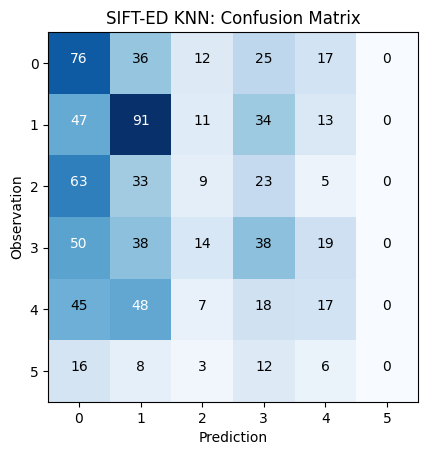

In [11]:
# Compute evaluation given classification results 
def evaluate(Y_hat,Y_truth): 
    print(classification_report(Y_truth,Y_hat,target_names=TARGET_NAMES))
    cm = confusion_matrix(Y_truth, Y_hat)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.title("SIFT-ED KNN: Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Observation")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

evaluate(res,test_Y)

From our report and confusion matrix, you can see our model struggles to accurately classify our data, with low accuracy scores across the board. Especially when it comes to the *trash* class. 

TODO DESCRIBE CONFUSION MATRIX
